In [5]:
%pip install scipy

     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------------------------- ------------ 41.0/60.8 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 459.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/41.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/41.2 MB 8.6 MB/s eta 0:00:05
    --------------------------------------- 0.7/41.2 MB 7.2 MB/s eta 0:00:06
   - -------------------------------------- 1.1/41.2 MB 8.4 MB/s eta 0:00:05
   - -------------------------------------- 1.6/41.2 MB 9.5 MB/s eta 0:00:05
   -- ------------------------------------- 2.2/41.2 MB 10.2 MB/s eta 0:00:04
   -- ------------------------------------- 2.8/41.2 MB 10.1 MB/s eta 0:00:04
   --- ------------------------------------ 3.2/41.2 MB 10.3 MB/s eta 0:00:04
   --- ------------------------------------ 4.0/41.2 MB 10.7 MB/s eta 0:00:04
   --


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\mijsters\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the folder where your JSON files are located
folder_path = "Pilot Data"  

# Get a list of all JSON files in the folder
json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

# Define the questions to track
target_questions = {
    "I felt I was in control of the bar's movement.": {'delay': [], 'no_delay': []},
    "I found the task difficult.": {'delay': [], 'no_delay': []},
}

data_for_plot = []

# Loop over all JSON files
for json_file in json_files:
    file_path = os.path.join(folder_path, json_file)
    
    # Load the JSON file
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    # Keep a counter to track the block number for the questions
    block_counter = 0
    questions_in_block = 0
    participant_id = json_file.split("_")[1]

    # Enumerate over each entry in the JSON file to find the survey responses for the target questions
    for i, entry in enumerate(data):
        if entry.get("trial_type") == "survey-likert":
            response = entry.get("response", {})
            for question in target_questions:
                if question in response:
                    # Backtrack to find the last trial with "blockType"
                    block_type = None
                    for j in range(i - 1, -1, -1):  # Iterate backwards
                        if "blockType" in data[j]:
                            block_type = data[j]["blockType"]
                            break
                    
                    # Determine condition label based on block_type
                    if block_type == "sync":
                        condition = "no_delay"
                    elif block_type == "wideasync":
                        condition = "delay"
                    else:
                        print(f"Warning: No blockType found for response in {json_file}")
                        continue  # Skip if no blockType
                    
                    # Append data for the CSV/export
                    data_for_plot.append({
                        "Participant": participant_id,
                        "Block": block_counter,
                        "Question": question,
                        "Condition": condition,  
                        "Response": int(response[question])  
                    })
                    # Increment questions_in_block
                    questions_in_block += 1

                    # If we've processed two questions, move to the next block
                    if questions_in_block == 2:
                        block_counter += 1
                        questions_in_block = 0  # Reset for the next block


df = pd.DataFrame(data_for_plot)

# Export the DataFrame to CSV
output_csv_path = "Pilot Data\survey_responses_with_participants.csv"
df.to_csv(output_csv_path, index=False, encoding='utf-8')

C:\Users\mijsters\AppData\Local\Temp\ipykernel_32840\263257401.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Response", data=question_data, palette={"no_delay": "red", "delay": "blue"})


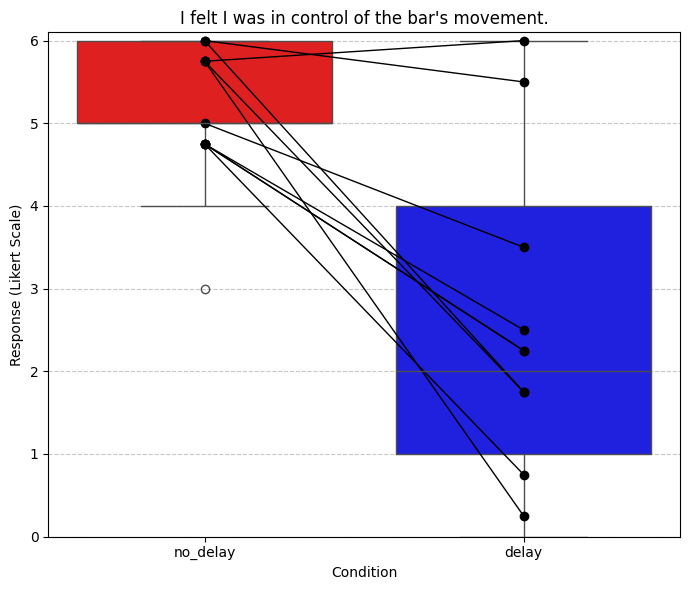

C:\Users\mijsters\AppData\Local\Temp\ipykernel_32840\263257401.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Response", data=question_data, palette={"no_delay": "red", "delay": "blue"})


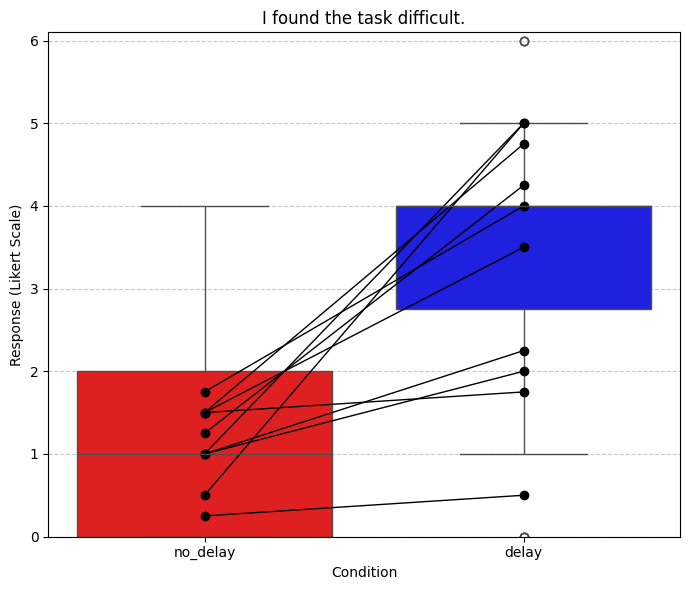

In [12]:
import pandas as pd

# Load the CSV file containing the survey responses
csv_file_path = "Pilot Data/survey_responses_with_participants.csv"
df = pd.read_csv(csv_file_path)

# Create a new DataFrame to calculate the average response per participant per condition and question
avg_responses = df.groupby(["Participant", "Condition", "Question"])["Response"].mean().reset_index()

# Iterate through the target questions and plot separately
for question, _ in target_questions.items():
    # Create a new figure for each question
    plt.figure(figsize=(7, 6)) 

    # Filter the data for the current question
    question_data = df[df["Question"] == question]
    
    # Create the boxplot
    sns.boxplot(x="Condition", y="Response", data=question_data, palette={"no_delay": "red", "delay": "blue"})
    
    # Plot the connected average line for each participant
    for participant in question_data["Participant"].unique():
        # Get the average responses for this participant
        participant_data = avg_responses[(avg_responses["Participant"] == participant) & (avg_responses["Question"] == question)]
        
        # Check if the participant has responses in both conditions
        if len(participant_data[participant_data["Condition"] == "no_delay"]) > 0 and len(participant_data[participant_data["Condition"] == "delay"]) > 0:
            no_delay_response = participant_data[participant_data["Condition"] == "no_delay"]["Response"].values[0]
            delay_response = participant_data[participant_data["Condition"] == "delay"]["Response"].values[0]
            
            # Plot the line connecting the average responses for delay and no_delay
            plt.plot(["no_delay", "delay"], [no_delay_response, delay_response], color='black', linestyle='-', marker='o', linewidth=1)

    # Customize the plot
    plt.title(question)  # Set title as the question text
    plt.xlabel("Condition")
    plt.ylabel("Response (Likert Scale)")
    plt.ylim(0, 6.1)  # Assuming Likert scale responses from 0 to 6
    plt.grid(axis='y', linestyle="--", alpha=0.7)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [11]:
import pandas as pd
from scipy import stats

# Load the CSV file containing the survey responses
csv_file_path = "Pilot Data/survey_responses_with_participants.csv"
df = pd.read_csv(csv_file_path)

# Filter the data for the "control" question
control_question = "I felt I was in control of the bar's movement."
control_data = df[df["Question"] == control_question]

# Make sure we only have the two conditions
control_data = control_data[control_data["Condition"].isin(["delay", "no_delay"])]

# Group by Participant and Condition, then calculate the mean response
control_data_grouped = control_data.groupby(["Participant", "Condition"])["Response"].mean().reset_index()

# Pivot the data to have a column for each condition (delay, no_delay)
pivot_data = control_data_grouped.pivot(index="Participant", columns="Condition", values="Response")

# Check for normality (optional step for choosing the correct test)
_, p_value_no_delay = stats.shapiro(pivot_data["no_delay"])  # Shapiro-Wilk test for normality
_, p_value_delay = stats.shapiro(pivot_data["delay"])

print(f"Shapiro-Wilk test p-value for no_delay: {p_value_no_delay}")
print(f"Shapiro-Wilk test p-value for delay: {p_value_delay}")

print(pivot_data["no_delay"])
print(pivot_data["delay"])
# If both conditions are normally distributed, perform a paired t-test
if p_value_no_delay > 0.05 and p_value_delay > 0.05:
    print("Data is normally distributed. Performing paired t-test...")
    t_stat, p_ttest = stats.ttest_rel(pivot_data["no_delay"], pivot_data["delay"])
    print(f"Paired t-test result: t-statistic = {t_stat}, p-value = {p_ttest}")
else:
    print("Data is not normally distributed. Performing Wilcoxon signed-rank test...")
    # If data is not normally distributed, use the Wilcoxon signed-rank test
    w_stat, p_wilcoxon = stats.wilcoxon(pivot_data["no_delay"], pivot_data["delay"])
    print(f"Wilcoxon signed-rank test result: statistic = {w_stat}, p-value = {p_wilcoxon}")


Shapiro-Wilk test p-value for no_delay: 0.007462054945867072
Shapiro-Wilk test p-value for delay: 0.24403003418413205
Participant
5adef850eb60400001539109    4.75
5d7472ad3bc4020015f3bb56    5.75
63cff262503b56190be3eb18    4.75
6562025a6e3331528cf8fb3d    4.75
6612c945cebe319d923b80f8    5.75
66b5a7ae36e5b931db863954    5.00
6773fc8590d7b54b0d580e6b    6.00
6785b7dd6705050739feb0ad    6.00
678fa07cd72c816bac76bda5    5.75
67ac2151e5b37e0b91a5af0e    4.75
Name: no_delay, dtype: float64
Participant
5adef850eb60400001539109    2.50
5d7472ad3bc4020015f3bb56    1.75
63cff262503b56190be3eb18    0.75
6562025a6e3331528cf8fb3d    2.25
6612c945cebe319d923b80f8    0.25
66b5a7ae36e5b931db863954    3.50
6773fc8590d7b54b0d580e6b    5.50
6785b7dd6705050739feb0ad    1.75
678fa07cd72c816bac76bda5    6.00
67ac2151e5b37e0b91a5af0e    2.25
Name: delay, dtype: float64
Data is not normally distributed. Performing Wilcoxon signed-rank test...
Wilcoxon signed-rank test result: statistic = 1.0, p-value = 0.00